In [4]:
############################ 0. PREPARATION ############################

#-------------------------- import packages --------------------------
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Multiply, Add
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error as mse
from sklearn.compose import make_column_transformer
from NAM_models import ActivationLayer, FeatureNN, NAM

#-------------------------- import data --------------------------
'''we use the popular French Motor TPL insurance claim data '''
freq = pd.read_csv("data/freMTPL2freq.csv")
sev = pd.read_csv("data/freMTPL2sev.csv")

In [ ]:
############################ 1. PREPROCESSING ############################

random.seed(2000)

#-------------------------- merge/filter claim data --------------------------
# complete claim severity data
claimsev = sev.merge(freq, on = 'IDpol', how = 'left')
claimsev = claimsev.drop(columns = ['ClaimNb', 'Exposure'])

# drop ID
claimfreq = freq.drop(columns = "IDpol")


#-------------------------- subsample and split --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    claimfreq.drop("ClaimNb", axis = 1), claimfreq["ClaimNb"], random_state = 2025)

In [ ]:
#-------------------------- feature transformation --------------------------
# define transformer
ct = make_column_transformer(
    ("passthrough", ["Exposure"]),
    (OrdinalEncoder(), ["Area", "VehGas"]),
    (OneHotEncoder(), ["VehBrand", "Region"]),
    remainder = StandardScaler(),
    verbose_feature_names_out = False
)


# fit & transform
train = ct.fit_transform(X_train).toarray()
test = ct.transform(X_test).toarray()
feature_names = ct.get_feature_names_out()  # get the columns' names


# number of columns for each feature after transformation
feature_expansion = {} # empty dictionary to store the output
for original_feature in X_train.columns:
    # For each original feature, count how many transformed feature names start with it
    count = sum(fn.startswith(original_feature) for fn in feature_names)
    feature_expansion[original_feature] = count
feature_expansion

{'Exposure': 1,
 'VehPower': 1,
 'VehAge': 1,
 'DrivAge': 1,
 'BonusMalus': 1,
 'VehBrand': 11,
 'VehGas': 1,
 'Area': 1,
 'Density': 1,
 'Region': 21}

In [ ]:
############################ 2. NAM ############################

#-------------------------- define functions to create NAM and subnets --------------------------
'''create subnetwork for each feature/group of features'''
def create_subnet(input_shape):
    model = Sequential([
        Dense(64, activation = 'leaky_relu'),
        Dense(32, activation = 'leaky_relu'),
        Dense(1, activation = 'softplus')  # output layer for the subnet, assuming a scalar output
    ])
    return model


'''create NAM'''
def create_nam_model(feature_expansion):
    inputs = [] # store the input layer of each subnet 
    sub_outputs = [] # store the output of each subnetwork
    for name, num_columns in feature_expansion.items():
        input_layer = Input(name = name, shape = (num_columns,))
        inputs.append(input_layer)
        
        if name == "Exposure":
            # assume the first input is the exposure, we directly use it without a subnet
            exposure_input = input_layer
        else:
            # create subnet for each feature/group of features
            subnet = create_subnet(num_columns)
            sub_output = subnet(input_layer)
            sub_outputs.append(sub_output)
    
    # concatenate the outputs of the subnets and sum them
    sum_of_subs = Add()(sub_outputs)
    
    # multiply the exposure input by the sum of subnets' outputs
    final_output = Multiply()([exposure_input, sum_of_subs])
    
    # final model
    model = Model(inputs = inputs, outputs = final_output)
    return model

In [ ]:
# -------------------------- fit a NAM to training data --------------------------

model_NAM = create_nam_model(feature_expansion)  # create NAM
model_NAM.compile(
    optimizer="adam", loss="poisson", metrics=["mean_squared_error", "poisson"]
)
es = EarlyStopping(patience=5, restore_best_weights=True, verbose=1)

# training data need to be split into different arrays, each correponds to input for a particular subnet
start = 0
X_train_split = []
for size in feature_expansion.values():
    end = start + size
    X_train_split.append(train[:, start:end])
    start = end

# fit the model
model_NAM.fit(
    X_train_split,
    y_train,
    epochs = 50,
    batch_size = 128,
    callbacks = [es],
    validation_split = 0.2,
)

Epoch 1/50
3179/3179 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.3960 - mean_squared_error: 0.7235 - poisson: 0.3960 - val_loss: 0.2093 - val_mean_squared_error: 0.0576 - val_poisson: 0.2093
Epoch 2/50
3179/3179 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2111 - mean_squared_error: 0.0588 - poisson: 0.2111 - val_loss: 0.2087 - val_mean_squared_error: 0.0574 - val_poisson: 0.2087
Epoch 3/50
3179/3179 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2077 - mean_squared_error: 0.0576 - poisson: 0.2077 - val_loss: 0.2074 - val_mean_squared_error: 0.0576 - val_poisson: 0.2074
Epoch 4/50
3179/3179 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2055 - mean_squared_error: 0.0558 - poisson: 0.2055 - val_loss: 0.2074 - val_mean_squared_error: 0.0577 - val_poisson: 0.2074
Epoch 5/50
3179/3179 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2071 - mean_squared_error: 0.0574 - poisson: 0.2071 - val_loss: 0.2066 - val_mean_squared_error: 0.0574 - val_poisson: 0.2066
Epoch 6/50
3179/3179 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/s

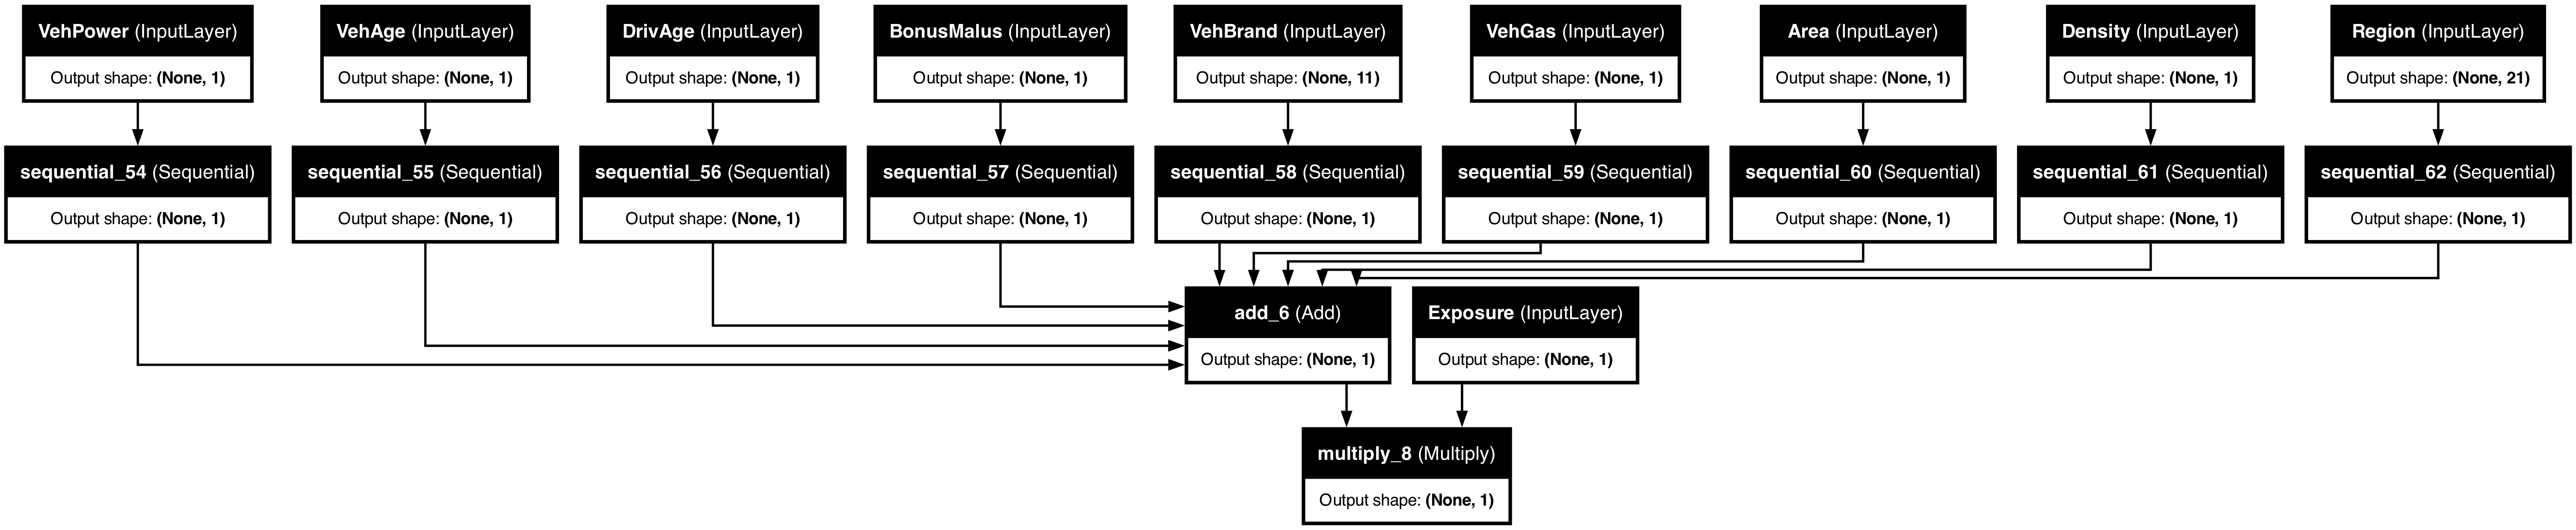

In [ ]:
#-------------------------- plot model --------------------------
plot_model(model_NAM, show_layer_names = True, show_shapes = True)

In [ ]:
#-------------------------- evaluate on testing data --------------------------

# split testing data into different sets
start = 0
X_test_split = []
for size in feature_expansion.values():
    end = start + size
    X_test_split.append(test[:, start:end])
    start = end

# evaluation
nam_poisson_loss, nam_mse, _ = model_NAM.evaluate(X_test_split, y_test)
print(f"NAM test set metrics ~ Poisson loss: {nam_poisson_loss:.4f}, MSE: {nam_mse:.4f}")

5297/5297 ━━━━━━━━━━━━━━━━━━━━ 2s 427us/step - loss: 0.2042 - mean_squared_error: 0.0550 - poisson: 0.2042
NAM test set metrics ~ Poisson loss: 0.2037, MSE: 0.0555


In [ ]:
############################ 3. GLM ############################

#-------------------------- preprocessing --------------------------
'''we want to use dummy encoding for VehBrand and Region so 2 columns need
to be removed from both training and test data. These 2 columns are the reference
levels for VehBrand and Region. Choose B12 for VehBrand and Centre for Region.'''

# separate the offset term (or exposure)
offset_train = train[:, 0]
offset_test = test[:, 0]

# index for reference level in feature_names
ref_index = [np.where(feature_names == "VehBrand_B12")[0][0],
             np.where(feature_names == "Region_Centre")[0][0]]
ref_index.append(0) # Exposure

# remove reference levels
train_dummy = np.delete(train, ref_index, axis = 1)
test_dummy = np.delete(test, ref_index, axis = 1)
feature_dummy = [feature for i, feature in enumerate(feature_names) if i not in ref_index]

# add a constant to the model (intercept)
train_dummy = sm.add_constant(train_dummy)
test_dummy = sm.add_constant(test_dummy)

In [ ]:
train_dummy

array([[ 1.        ,  5.        ,  0.        , ..., -0.17616054,
        -0.5605813 ,  3.64822046],
       [ 1.        ,  1.        ,  1.        , ...,  0.24828561,
        -0.62454786, -0.43160256],
       [ 1.        ,  3.        ,  0.        , ...,  0.38976766,
         1.03858267, -0.02465274],
       ...,
       [ 1.        ,  4.        ,  1.        , ...,  0.88495484,
        -0.62454786,  0.18637693],
       [ 1.        ,  4.        ,  1.        , ...,  0.10680356,
        -0.62454786,  2.01588833],
       [ 1.        ,  2.        ,  0.        , ..., -0.60060669,
         1.29444891, -0.40893828]])

In [ ]:
#-------------------------- fit a GLM model --------------------------
model_GLM = sm.GLM(y_train, train_dummy, family = sm.families.Poisson(), offset = offset_train)
results = model_GLM.fit()
# results.summary()

In [ ]:
#-------------------------- evaluation --------------------------
GLM_pred = results.predict(test_dummy, offset = offset_test)
GLM_mse = mse(y_test, GLM_pred)
print(GLM_mse)

0.055278047495470876


In [ ]:
# Calculate the Poisson loss for the GLM model which Keras uses
glm_poisson_loss = keras.losses.Poisson()(y_test, GLM_pred).numpy()
glm_poisson_loss

0.20162305

In [95]:
############################ 4. NEURAL NETWORKS ############################

#-------------------------- preprocessing --------------------------
# separate exposure with other features
train_exposure = train[:,0]
test_exposure = test[:,0]
train_NN = train[:,1:]
test_NN = test[:,1:]

In [99]:
#-------------------------- fit a deep NN --------------------------

'''Define model architecture'''
# input layers
exposure = Input(shape=(1,))
other_inputs = Input(shape = train_NN.shape[1:])

# dense layers
x = Dense(64, "leaky_relu")(other_inputs)
x = Dense(64, "leaky_relu")(x)
lambda_ = Dense(1, "exponential")(x)

# final output
out = Multiply()([lambda_, exposure])
model_NN = Model([exposure, other_inputs], out)

# regularization
es = EarlyStopping(patience = 5, restore_best_weights = True, verbose = 0)

# compile the model
model_NN.compile(optimizer = "adam",
              loss = "poisson", 
              metrics = ['mean_squared_error', 'poisson'])

# fit
model_NN.fit([train_exposure, train_NN], y_train,
            epochs = 50,  
            batch_size = 32, 
            validation_split = 0.2,
            callbacks = [es])

Epoch 1/50
12713/12713 ━━━━━━━━━━━━━━━━━━━━ 6s 471us/step - loss: 0.2140 - mean_squared_error: 0.0591 - poisson: 0.2140 - val_loss: 0.2070 - val_mean_squared_error: 0.0574 - val_poisson: 0.2070
Epoch 2/50
12713/12713 ━━━━━━━━━━━━━━━━━━━━ 6s 473us/step - loss: 0.2059 - mean_squared_error: 0.0568 - poisson: 0.2059 - val_loss: 0.2065 - val_mean_squared_error: 0.0583 - val_poisson: 0.2065
Epoch 3/50
12713/12713 ━━━━━━━━━━━━━━━━━━━━ 6s 492us/step - loss: 0.2048 - mean_squared_error: 0.0570 - poisson: 0.2048 - val_loss: 0.2052 - val_mean_squared_error: 0.0575 - val_poisson: 0.2052
Epoch 4/50
12713/12713 ━━━━━━━━━━━━━━━━━━━━ 6s 499us/step - loss: 0.2046 - mean_squared_error: 0.0564 - poisson: 0.2046 - val_loss: 0.2068 - val_mean_squared_error: 0.0572 - val_poisson: 0.2068
Epoch 5/50
12713/12713 ━━━━━━━━━━━━━━━━━━━━ 6s 478us/step - loss: 0.2072 - mean_squared_error: 0.0606 - poisson: 0.2072 - val_loss: 0.2052 - val_mean_squared_error: 0.0572 - val_poisson: 0.2052
Epoch 6/50
12713/12713 ━━━━━━━

In [100]:
#-------------------------- evaluate on test set --------------------------
nn_poisson_loss, nn_mse, _ = model_NN.evaluate([test_exposure, test_NN], y_test)
model_NN.evaluate([test_exposure, test_NN], y_test)
print(f"NN test set metrics ~ Poisson loss: {nn_poisson_loss:.4f}, MSE: {nn_mse:.4f}")

5297/5297 ━━━━━━━━━━━━━━━━━━━━ 1s 276us/step - loss: 0.2025 - mean_squared_error: 0.0546 - poisson: 0.2025
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 1s 274us/step - loss: 0.2025 - mean_squared_error: 0.0546 - poisson: 0.2025
NN test set metrics ~ Poisson loss: 0.2019, MSE: 0.0551


In [101]:
# Print all the results
print(f"GLM test set metrics \t Poisson loss: {glm_poisson_loss:.4f} \t MSE: {GLM_mse:.4f}")
print(f"NN test set metrics \t Poisson loss: {nn_poisson_loss:.4f} \t MSE: {nn_mse:.4f}")
print(f"NAM test set metrics \t Poisson loss: {nam_poisson_loss:.4f} \t MSE: {nam_mse:.4f}")

GLM test set metrics 	 Poisson loss: 0.2016 	 MSE: 0.0553
NN test set metrics 	 Poisson loss: 0.2019 	 MSE: 0.0551
NAM test set metrics 	 Poisson loss: 0.2037 	 MSE: 0.0555
